<a href="https://colab.research.google.com/github/SurajK02/prjkt_sptnk/blob/master/CAPP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **<center>Stock Price Prediction using Machine Learning and Deep Learning models</Center>**






**Presented by**:
*   C20007 - Archit Jamaiyar
*   C20017 - Nixon Sebastian    
*   C20022 - Sasikumar Krishnan 
*   C20030 - Suraj Kesavan      
*   C20031 - Vinod kumar        
*   C20032 - Kaushik B          


**Guided by**:
*   Prof. Jaydip Sen





---



Stock Price Prediction has become a game changer for the Trading industry with the increasing number of investors. A lot of emerging main stream platforms and mobile apps is evidence to this. These platforms are as good as the algorithms employed, their accuracy and how much further forecast can be done.

We aim to provide an analysis for different machine learning and deep learning models prediction of the stock prices using the 5 min interval data of the **Century Textiles**



---



# 1. Imputing the Dataset

In [ ]:
# Importing neccessary libraries

import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Reading the data from excel.

stock_df = pd.read_excel("century textiles.xlsx")

In [ ]:
# Getting initial look at the data.

stock_df.head()

,century textile,time,open,high,low,close,volume
0,2013-01-01,9:20:000,416.15,419.65,416.15,417.50,15474
1,2013-01-01,9:25:000,417.50,418.70,417.20,418.50,8493
2,2013-01-01,9:30:000,418.50,418.80,418.25,418.40,4418
3,2013-01-01,9:35:000,418.35,418.90,418.25,418.45,2023
4,2013-01-01,9:40:000,418.60,418.75,418.25,418.30,2690


In [ ]:
# Getting basic information about the dataset to check for datatypes of variables and missing values.

stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39816 entries, 0 to 39815
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   century textile  39816 non-null  datetime64[ns]
 1   time             39816 non-null  object        
 2   open             39816 non-null  float64       
 3   high             39816 non-null  float64       
 4   low              39816 non-null  float64       
 5   close            39816 non-null  float64       
 6   volume           39816 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.1+ MB


In [ ]:
# renaming the appropriate column names 

stock_df.rename(columns = {'century textile':'date'}, inplace = True)

In [ ]:
day_map = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5}

In [ ]:
reverse_day_map = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday'}

In [ ]:
# Generating time slot from 9:30 to 3:30

time_list = pd.date_range(start='09:30:00', periods=73, freq='5T').strftime("%H:%M:%S").to_list()

In [ ]:
def clean_data(dataframe):
    
    # Extracting day, week and year from the date variable

    dataframe['Day'] = dataframe.date.dt.strftime('%A')
    dataframe['Week'] = dataframe.date.dt.week
    dataframe['Year'] = dataframe.date.dt.year
    
    # Dropping if any records recorded on Saturday or Sunday.

    dataframe = dataframe[~(dataframe.Day.isin(['Sunday','Saturday']))]
    
    # Dropping duplicate records if anything present

    dataframe = dataframe.drop_duplicates()
    
    # If the first day of the record is not monday finding the occurance of first monday and starting the dataframe from there

    first_record = dataframe.loc[0,:]
    if first_record.Day != 'Monday':
        for index, day in enumerate(dataframe.Day):
            if day == 'Monday':
                dataframe = dataframe.loc[index:].reset_index(drop=True)
                break
                
    # If any of the last days in current year belong to the 1 week of the next year, then year for that record set to the next year.

    year_mask = dataframe[(dataframe.date.dt.month==12)&(dataframe.Week==1)].index
    dataframe.loc[year_mask,'Year'] = dataframe.Year+1
    
    return dataframe

In [ ]:
def get_missing_days_minutes(dataframe, minutes=False):
    
    columnNames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    # Grouping by Year,Week and Day and
    # Converting multi-index (Year,Week,Day) -> (Year,Week)
    
    combined_df = pd.DataFrame(dataframe.groupby(['Year','Week','Day']).size()).rename(columns={0:'Count'}).unstack('Day')
    
    missing_values = []
    for day in columnNames:
        
        # For a given day there should 73 records present if day starts at 9:30 and end at 3:30.
        # If not 73 records some time slots are missing in the given day, capturing those days.
        if minutes:
            missing_values.extend([(val[0],val[1],day) for val in 
                                   combined_df[combined_df[('Count',day)]<73].index.to_list()])
        # Getting the missing day present in a week in the given year
        else:
            missing_values.extend([(val[0],val[1],day) for val in 
                                   combined_df[combined_df[('Count',day)].isna()].index.to_list()])
            
    # Sorting the list by year, week
    
    missing_values = [(row[0],row[1],row[2]) for i, row in 
                      pd.DataFrame(missing_values).sort_values(by=[0,1], ascending=[True,True]).iterrows()]
    return missing_values

In [ ]:
def create_day_missing_records(after, dataframe):
    
    # Getting the previous day date
    # If previous day is friday, create next day as Monday otherwise next day value
    
    previous_date = dataframe.loc[after,'date']
    if day_map[previous_date.strftime('%A')] != 5:
        date_to_be_filled = previous_date+datetime.timedelta(days=1)
    else:
        date_to_be_filled = dataframe.loc[after,'date']+datetime.timedelta(days=3)
    
    # converting to pandas datetime object so extracting week, year will be easy 
    
    date_to_be_filled = pd.to_datetime(date_to_be_filled)
    
    # Creating 73 records for each missing day and filling date, day, week and year value
    # Appending the records created at appropriate index
    
    for ind,val in enumerate(range(after,after+73)):
        missing = pd.DataFrame({'date': date_to_be_filled, 'time':time_list[ind],
                                'Day':day_map[date_to_be_filled.strftime('%A')],
                                'Week':date_to_be_filled.week,
                                'Year':date_to_be_filled.year},index=[val+0.5])
        dataframe = dataframe.append(missing, ignore_index=False)
        dataframe = dataframe.sort_index().reset_index(drop=True)
    
    return dataframe

In [ ]:
def fill_missing_days(dataframe):
    
    # getting the missing values

    missing_values = get_missing_days_minutes(dataframe=dataframe)
    
    # Encoding the day value for ease of calculation
    
    dataframe.Day = dataframe.Day.replace(day_map)
    
    for val in missing_values:
    
    # If the missing day in the first week of the year then it has to locate last year's last week and last day index
    
        if val[1] != 1:
        
            # If the missing day is monday then it has to locate the friday's index 
            # Otherwise the previous day index
        
            if day_map[val[2]] != 1: 
                previous_day_index= dataframe[(dataframe.Year==val[0])&(dataframe.Week==val[1])
                                               &(dataframe.Day==day_map[val[2]]-1)].index[-1]
                dataframe = create_day_missing_records(after=previous_day_index, dataframe=dataframe)
            else:
                previous_day_index= dataframe[(dataframe.Year==val[0])&(dataframe.Week==val[1]-1)
                                               &(dataframe.Day==5)].index[-1]
                dataframe = create_day_missing_records(after=previous_day_index, dataframe=dataframe)
        elif val[1] == 1:
            previous_day_index= dataframe[(dataframe.Year==val[0]-1)&(dataframe.Week==52)&(dataframe.Day==5)].index[-1]
            dataframe = create_day_missing_records(after=previous_day_index, dataframe=dataframe)
    
    # Forward filling the missing values present in the open,high,low,close volume columns.
    
    dataframe.fillna(method='ffill', inplace=True)
    return dataframe

In [ ]:
def create_time_missing_records(after, timestamp, dataframe, first_record=False):
    
    # Creating missing record
    
    missing_time = pd.DataFrame({'date': dataframe.loc[after,'date'], 'time':timestamp,
                                         'Day':dataframe.loc[after,'Day'],
                                         'Week':dataframe.loc[after,'Week'],
                                         'Year':dataframe.loc[after,'Year']},
                                         index=[(after-1)+0.5] if first_record else [after+0.5])
    
    #Adding it to dataframe and reseting the index
    
    dataframe = dataframe.append(missing_time, ignore_index=False)
    dataframe = dataframe.sort_index().reset_index(drop=True)
    
    return dataframe

In [ ]:
def fill_missing_timeslots(dataframe):
    
    # Changing the encoded values in day to original format for ease of calulation
    
    dataframe.Day = dataframe.Day.replace(reverse_day_map)
    
    # Some timeslots are different format, changing to have same format throughout the dataset
    
    dataframe.time = pd.to_datetime(dataframe.time).dt.strftime("%H:%M:%S")
    
    # Chopping the timeslots, so everyday starts with 9:30 to 3:30
    dataframe = dataframe[dataframe.time.isin(time_list)]
    
    # If chopping removed entire day, filling those days again with proper time slots
    
    dataframe = fill_missing_days(dataframe=dataframe)
    
    dataframe.Day = dataframe.Day.replace(reverse_day_map)
    
    # Finding the day where timeslots are missing
    missing_values_minutes = get_missing_days_minutes(dataframe=dataframe, minutes=True)
    missing_val_minutes = []
    for val in missing_values_minutes:
        missing_time = sorted(list(set(time_list)-set(dataframe[(dataframe.Year==val[0])&
                                                                (dataframe.Week==val[1])&(dataframe.Day==val[2])].time)))
        missing_val_minutes.append((val[0],val[1],val[2],missing_time))
        
    for val in missing_val_minutes:
        for time in val[3]:
            if time != '09:30:00':
                prvious_timestamp = (pd.to_datetime(time) - datetime.timedelta(minutes=5)).strftime("%H:%M:%S")
                prvious_index = dataframe[(dataframe.Year==val[0])&(dataframe.Week==val[1])&(dataframe.Day==val[2])&
                                                                            (dataframe.time==prvious_timestamp)].index[0]
                dataframe = create_time_missing_records(after=prvious_index, timestamp=time, dataframe=dataframe)
            else:
                current_index = dataframe[(dataframe.Year==val[0])&(dataframe.Week==val[1])&
                                           (dataframe.Day==val[2])].index[0]
                dataframe = create_time_missing_records(after=current_index, timestamp=time, dataframe=dataframe,
                                                        first_record=True)
                
    dataframe.fillna(method='ffill', inplace=True)
    return dataframe

In [ ]:
def impute_data(dataframe):
    
    cleaned_data = clean_data(dataframe=dataframe)
    date_filled_data = fill_missing_days(dataframe=cleaned_data)
    time_filled_data = fill_missing_timeslots(dataframe=date_filled_data)
    return time_filled_data

In [ ]:
imputed_df = impute_data(dataframe = stock_df)

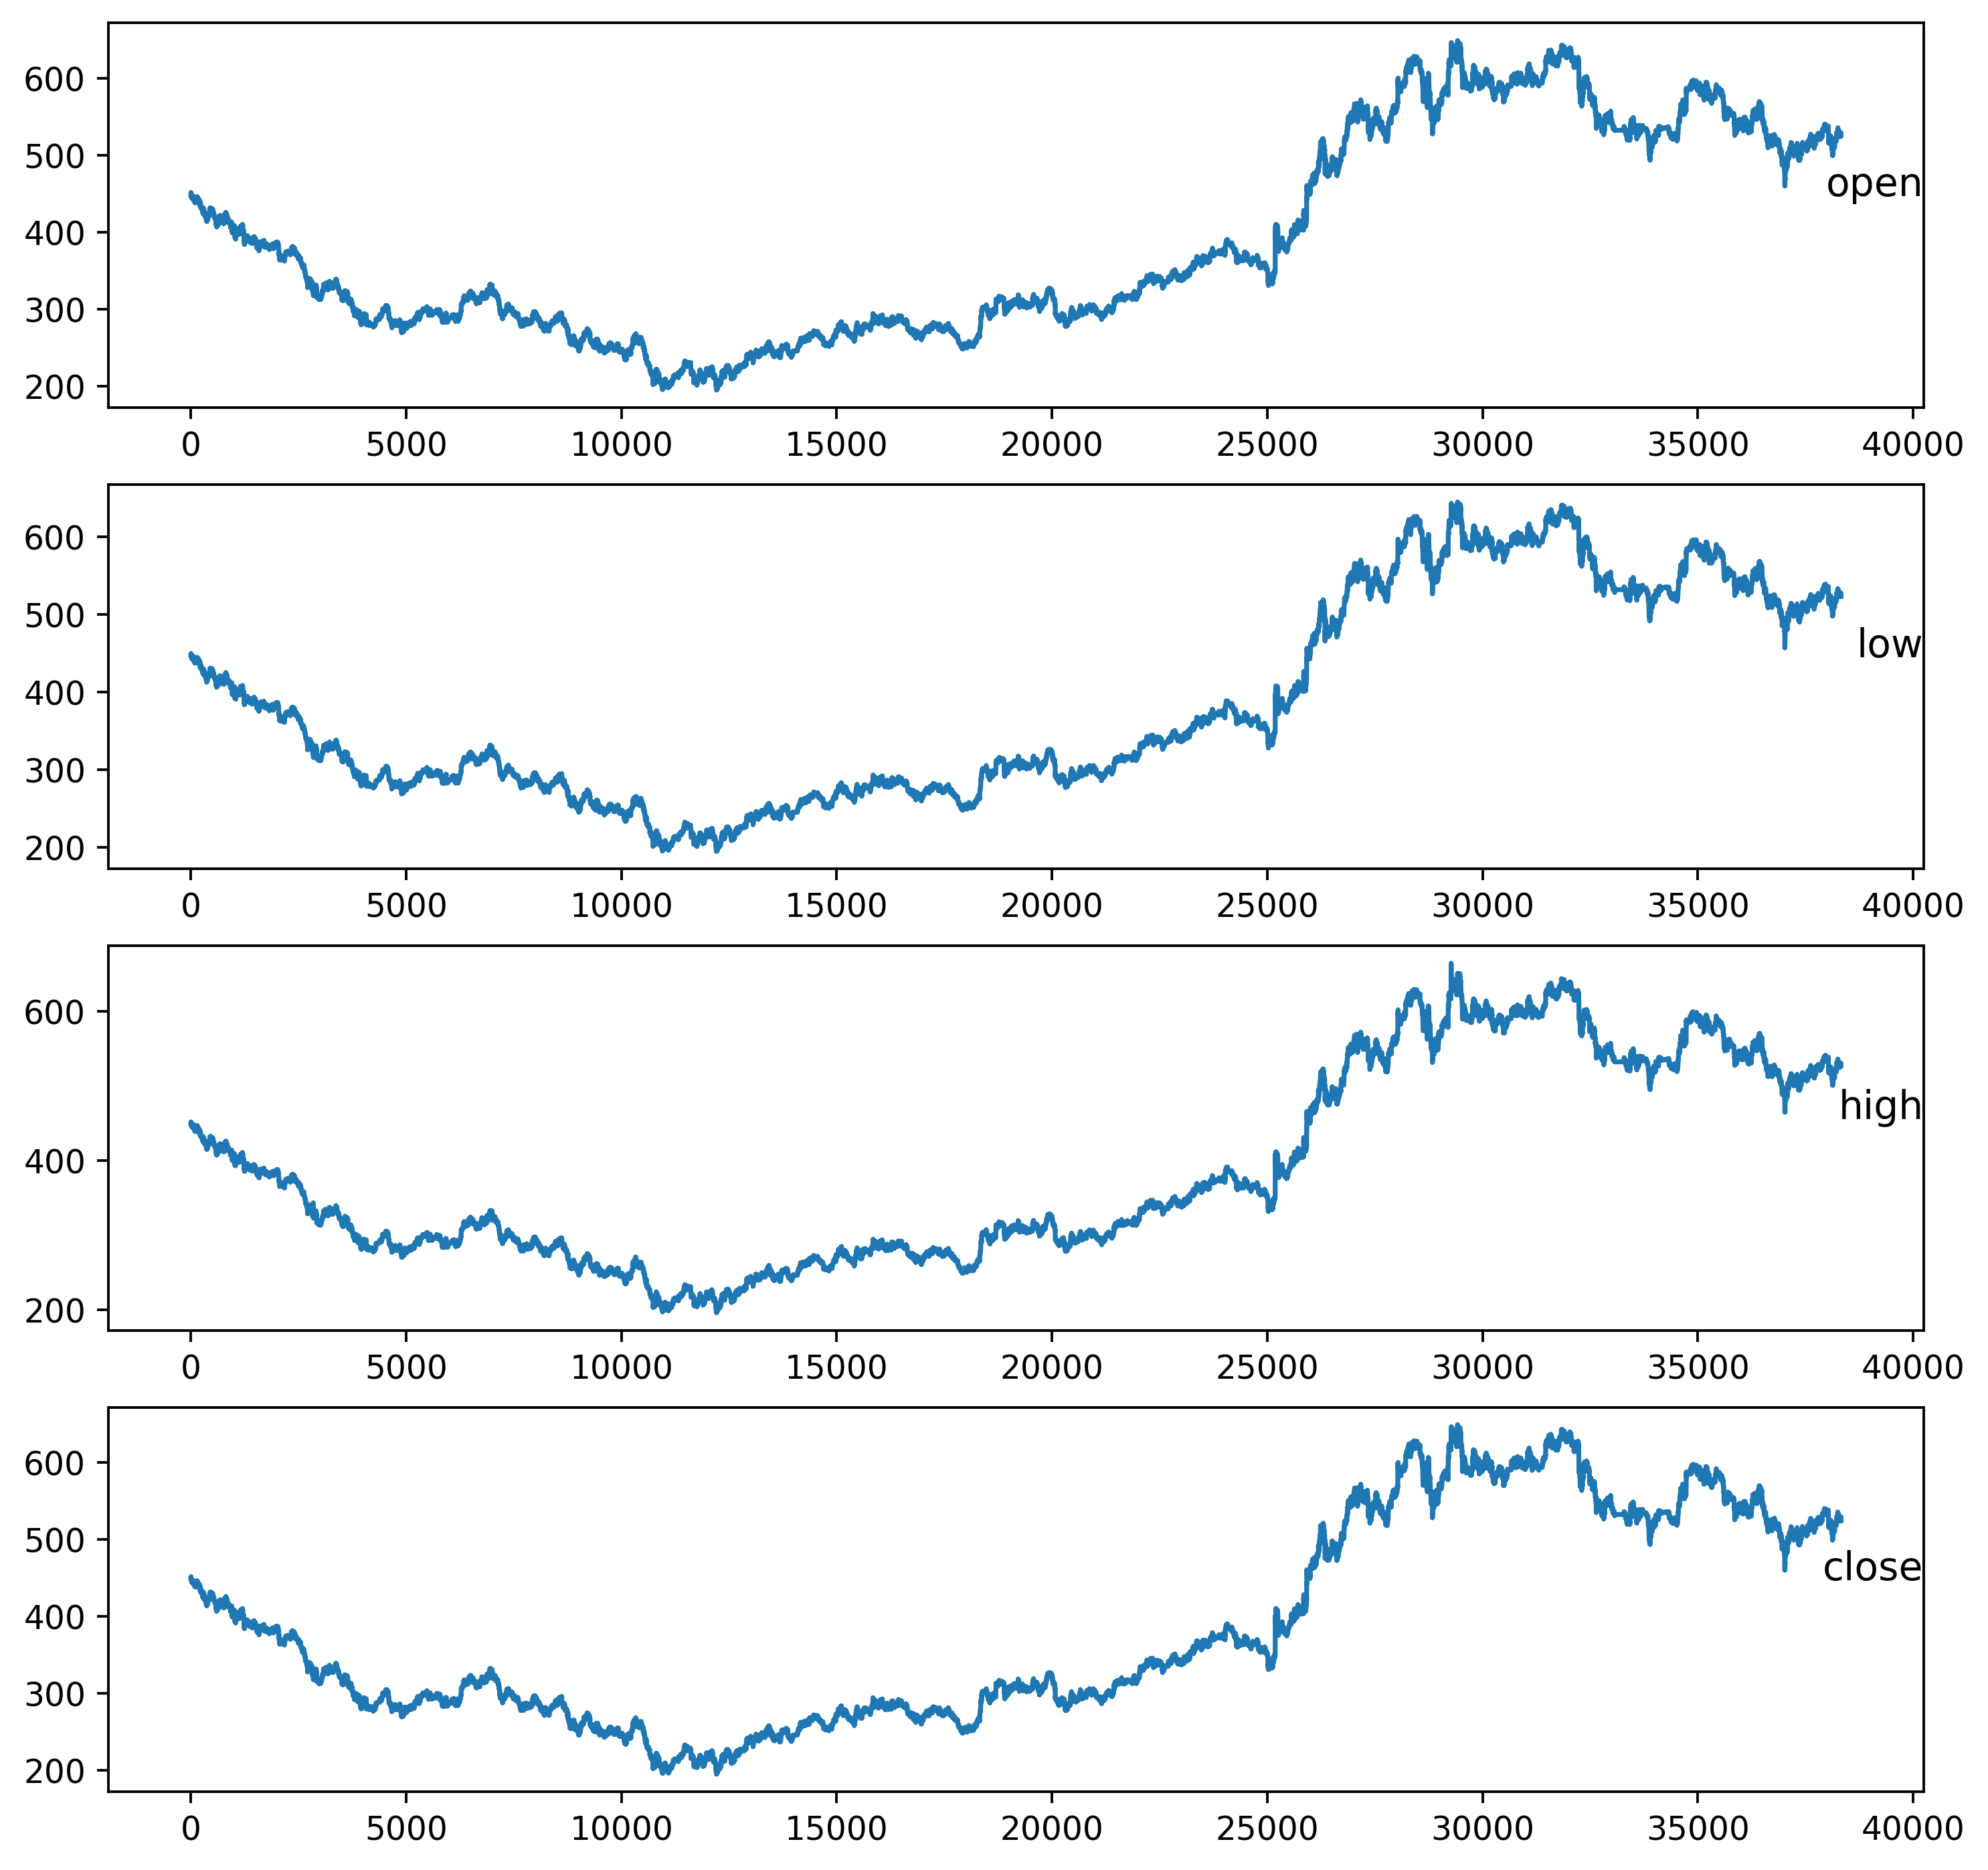

In [ ]:
# vizualising time series
plot_cols = ['open', 'low', 'high', 'close']

# plot each column
x=1
plt.figure(figsize=[10.0,10.0], dpi=350)
for i in plot_cols:
	plt.subplot(len(plot_cols), 1, x)
	plt.plot(stock_df[i])
	plt.title(i, y=0.5, loc='right')
	x += 1
plt.show()


# 2. Machine Learning Models

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from sklearn.ensemble import RandomForestRegressor as RFG
from sklearn.metrics import mean_squared_error
from sklearn import svm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#stock_df = pd.read_csv('/content/Century_data_imputed.csv')

In [ ]:
# processing data - converting the 5 min interval data to daily data by taking average for each day
def process_data(df):
  avg_daily_open_prices = []

  # averaging of daily prices  
  for day in range(0,len(df)-73+1,73):
      avg_daily_open_prices.append(round(np.mean(df[day:day+73]),4))

  # converting to dataframe
  average_prices_df = pd.DataFrame(avg_daily_open_prices)

  # split into train and test
  idx = round(average_prices_df.shape[0]*3/5)
  train_set = average_prices_df.iloc[:idx,:]
  test_set = average_prices_df.iloc[idx:,:]

  train_X = train_set[['low', 'high', 'close', 'volume']]
  train_y = train_set['open']

  test_X = test_set[['low', 'high', 'close', 'volume']]
  test_y = test_set['open']
  return train_X, train_y, test_X, test_y

In [ ]:
# evaluate model using rmse
def compute_rmse(actual, predictions):
    rmse = np.sqrt(mean_squared_error(np.array(actual).flatten(),np.array(predictions).flatten()))
    rmse_per_mean_target = rmse / np.mean(np.array(actual))
    print('==============================================================')
    print("RMSE: ", rmse)
    print('RMSE to Mean: ',rmse_per_mean_target)
    print('===============================================================')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.array(actual).reshape(-1,1), label='actual')
    plt.plot(np.array(predictions).reshape(-1,1), label='prediction')

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    plt.legend()
    

In [ ]:
# train test split
x_train_avg, y_train_avg, x_test_avg, y_test_avg = process_data(stock_df)


Random Forest

RMSE:  111.70584887011684
RMSE to Mean:  0.21379086469993036


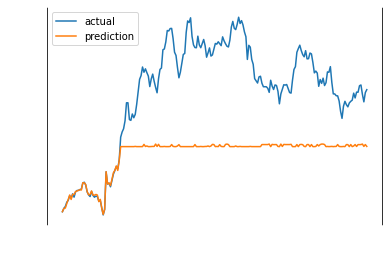

In [ ]:
# building model and evaluation score
rf=RFG(random_state=1)
rf.fit(x_train_avg,y_train_avg)
pred1=rf.predict(x_test_avg)
compute_rmse(actual=y_test_avg, predictions=pred1)

Support Vector Regressor

RMSE:  246.72856226224457
RMSE to Mean:  0.4722072586686812


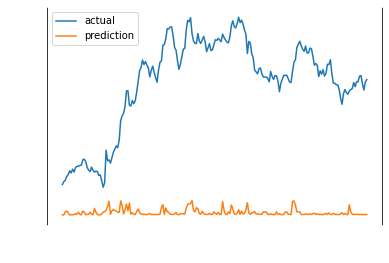

In [ ]:
# building model and evaluation score
model_svm = svm.SVR(kernel='rbf', gamma='scale', C=25)
model_svm.fit(x_train_avg,y_train_avg)
pred2=model_svm.predict(x_test_avg)
compute_rmse(actual=y_test_avg, predictions=pred2)

# 3. Deep Learning Models

## 3.a. Convolution Neural Networks

In [ ]:
# Importing neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error
from keras.utils import plot_model
import time
%matplotlib inline

In [ ]:
# Reading csv file as DataFrame

stock_df = pd.read_csv('/content/Century_data_imputed.csv')
stock_df.head()

,date,time,open,low,high,close,volume
0,07-01-2013,09:30:00,447.75,447.75,449.45,449.45,8112
1,07-01-2013,09:35:00,449.35,449.35,451.80,451.55,27301
2,07-01-2013,09:40:00,451.60,450.00,451.80,450.40,13994
3,07-01-2013,09:45:00,450.45,449.30,451.00,449.35,6240
4,07-01-2013,09:50:00,449.30,447.40,449.75,448.00,9152


In [ ]:
# averaging the data from 5 min interval data to day wise data
def average(df, dtype):
    
    avg_daily_open_prices = []
    
    # 73 records per day
    for day in range(0,len(df)-73+1,73):
        avg_daily_open_prices.append(round(np.mean(df[day:day+73]),4))
        
    avg_daily_open_prices_np = np.array(avg_daily_open_prices)
    
    # univariate will have only open price
    if dtype.lower() == 'univariate':
        avg_daily_open_prices_np = avg_daily_open_prices_np.reshape(-1,1)
        
    return avg_daily_open_prices_np

In [ ]:
# train test data generation for univariate and multivariate
def generate_train_test_data(df, dtype):
    
    if dtype.lower() == 'univariate':
        X = df.open
    elif dtype.lower() == 'multivariate':
        X = stock_df.drop(columns=['date', 'time'])
        
    averaged_X = average(X, dtype)
    
    # splitting dataset into train and test
    train_data = averaged_X[:round(averaged_X.shape[0]*3/5)]
    test_data = averaged_X[round(averaged_X.shape[0]*3/5):]
    
    train_data = train_data.reshape(train_data.shape[0]//5, 5, train_data.shape[1])
    test_data = test_data.reshape(test_data.shape[0]//5, 5, test_data.shape[1])
    
    return train_data, test_data

In [ ]:
#train_data, test_data = generate_train_test_data(stock_df, 'multivariate')

In [ ]:
# processing training data by creating a training set that is lagging by the time period shift
def process_train_data(train_df, week=1):
    
    train_df_reshaped = train_df.reshape(train_df.shape[0]*train_df.shape[1], train_df.shape[2])
    
    train_X_arr = []
    train_y_arr = []
    
    for i in range(len(train_df_reshaped)):
        
        temp_x = train_df_reshaped[i:i+(week*5), 0 if train_df_reshaped.shape[1]==1 else 1:]
        temp_y = train_df_reshaped[i+(week*5):i+((week*5)+5),0:1]
        
        if len(temp_x) == (week*5) and len(temp_y) == 5:
            train_X_arr.append(temp_x)
            train_y_arr.append(temp_y)
            
    train_X = np.array((train_X_arr)).reshape(len(train_X_arr), (week*5), len(train_X_arr[0][0]))
    train_y = np.array((train_y_arr)).reshape(len(train_y_arr), 5, 1)
    
    return train_X, train_y

In [ ]:
#train_X, train_y = process_train_data(train_data, week=1)

In [ ]:
# Function which construct dataframe with input lagged by the given value and output sequence

def process_test_data(data, shift_period, dtype):
    
    df = None
    
    shape_0, shape_1, shape_2 = data.shape
    
    data_reshaped = data.reshape(shape_0*shape_1, shape_2)
    
    if dtype.lower() == 'univariate':
        df = pd.DataFrame({'X':pd.Series(np.squeeze(data_reshaped)),'Y':pd.Series(np.squeeze(data_reshaped))})
        df.X = df.X.shift(periods=shift_period)
    elif dtype.lower() == 'multivariate':
        df = pd.concat([pd.DataFrame(data_reshaped[:,1:], columns=['X1', 'X2', 'X3', 'X4']), 
                        pd.DataFrame(data_reshaped[:,0], columns=['Y'])], axis=1)
        df.iloc[:,:-1] = df.iloc[:,:-1].shift(periods=shift_period)
        
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [ ]:
# Generating test dataframe, adding input column which is lagged by 5 days and output. 

#test_data_df = generate_shifted_df(data=test_data, shift_period=10, dtype='multivariate')

In [ ]:
#test_data_df.head()

In [ ]:
# normalize data
def normalize_data(data):
    shape_0, shape_1, shape_2 = data.shape
    normalized_data = normalize(data.reshape(shape_0*shape_1, shape_2))
    return data
    return normalized_data.reshape(shape_0, shape_1, shape_2)

In [ ]:
# building the convolution neural network architecture
def create_model(inp_shape):
    input_shape = inp_shape
    K.clear_session()
    inp = Input(shape=input_shape, dtype=np.float32)
    x = Conv1D(filters=16, kernel_size=3, activation='relu')(inp)
    x = MaxPool1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(units=5)(x)
    cnn_uni_model = Model(inp, x)
    print(cnn_uni_model.summary())
    return cnn_uni_model

In [ ]:
# training the model with the specified epoch and batch size
def train_model(model, X, y, epoch, batch_size):
    model.compile(optimizer='adam', loss='mse')
    x = normalize_data(X) if X.shape[2]==4 else X
    model.fit(x=x, y=y, epochs=epoch, batch_size=batch_size)
    return model

In [ ]:
# Evaluate the trained model
def eval_model(model, test_data, shift_period=5):
    
    predictions = []
    actual = []
    
    for i in range(0, len(test_data)-shift_period+1, 5):
        
        test_X_reshaped = None
        
        if len(test_data.columns) == 5:
            test_X = np.array(test_data.iloc[i:i+shift_period,0:4])
            test_X_reshaped = normalize_data(test_X.reshape(1,test_X.shape[0],test_X.shape[1]))
        else:
            test_X = np.array(test_data.iloc[i:i+shift_period,0:1])
            test_X_reshaped = test_X.reshape(1,test_X.shape[0],test_X.shape[1])
            
        # actual and predictied values
        yhat = model.predict(test_X_reshaped, verbose=0)
        predictions.append(yhat[0].reshape(-1,1))
        actual.append(np.array(test_data.iloc[i:i+5,-1]).reshape(-1,1))
        
    return predictions, actual

In [ ]:
# compurint the rmse and ploting predicted vs actual
def compute_rmse_and_plot(actual, predictions):
    rmse = np.sqrt(mean_squared_error(np.array(actual).flatten(),np.array(predictions).flatten()))
    rmse_per_mean_target = rmse / np.mean(np.array(actual))
    print('==============================================================')
    print("RMSE: ", rmse)
    print('RMSE to Mean: ',rmse_per_mean_target)
    print('===============================================================')
    plt.plot(np.array(actual).reshape(-1,1), c='blue', label='actual')
    plt.plot(np.array(predictions).reshape(-1,1), c='red', label='prediction')

In [ ]:
# execute the operations described above
def execute(df, config):
    model_type, week_inp, inp_shape, epoch, batch_size = config
    train_data, test_data = generate_train_test_data(df, model_type)
    train_X, train_y = process_train_data(train_data, week=week_inp)
    test_data_df = process_test_data(data=test_data, shift_period=week_inp*5, dtype=model_type)
    model = create_model(inp_shape=inp_shape)
    mod_viz = model
    trained_model = train_model(model=model, X=train_X, y=train_y, epoch=epoch, batch_size=batch_size)
    preds, actual = eval_model(model=trained_model, test_data=test_data_df, shift_period=week_inp*5)
    compute_rmse_and_plot(actual, preds)
    return mod_viz

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 16)             64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
20/20 [==============================] - 0s 2ms/step - loss: 123529.2868
Epoch 2/30
20/20 [======================

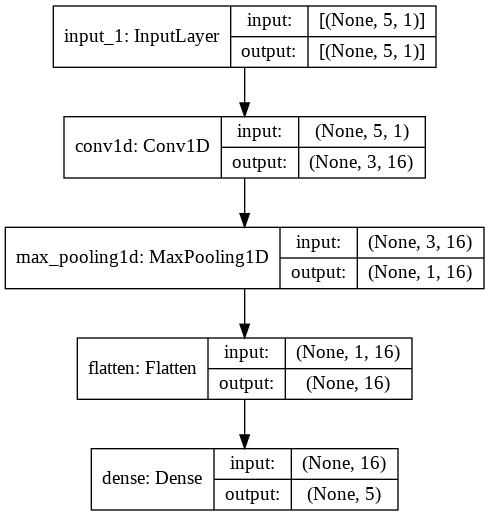

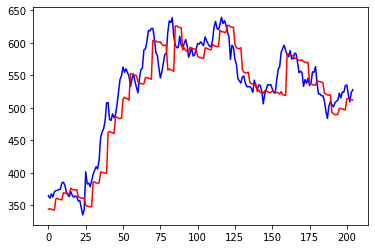

In [ ]:
# Univariate CNN Model with 5 days input and predicting 5 days output
start = time.time()
model = execute(stock_df, ('univariate', 1, (5,1), 30, 16))
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')
plot_model(model, to_file='cnn_uni_1.png', show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 16)             64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 389
Trainable params: 389
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
19/19 [==============================] - 0s 1ms/step - loss: 108104.3879
Epoch 2/30
19/19 [======================

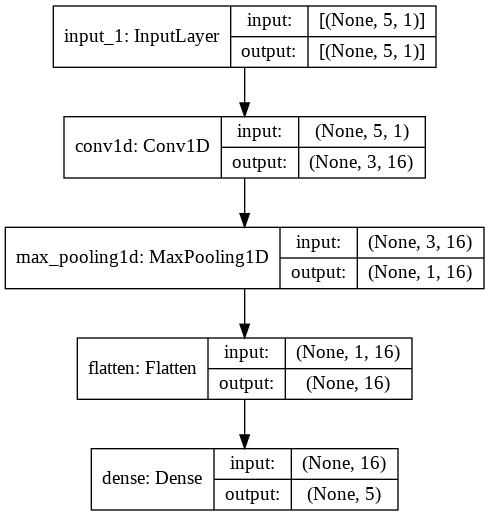

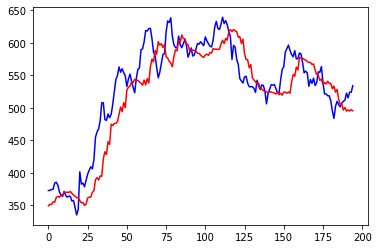

In [ ]:
# Univariate CNN Model with 10 days input and predicting 5 days output
start = time.time()
execute(stock_df, ('univariate', 2, (10,1), 30, 16))
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')
plot_model(model, to_file='cnn_uni_2.png', show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 16)             208       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1150
10/10 [==============================] - 0s 1ms/step - loss: 46137900.1818
Epoch 2/1150
10/10 [================

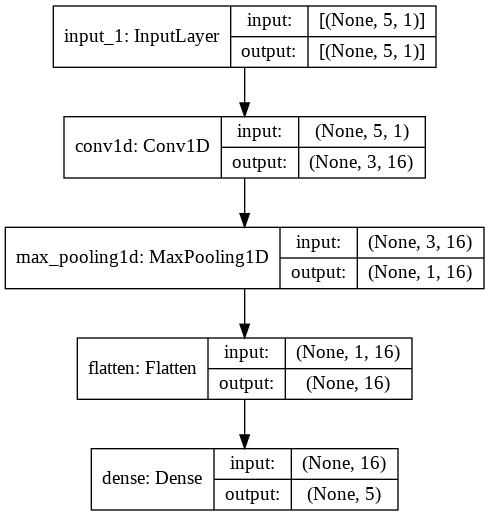

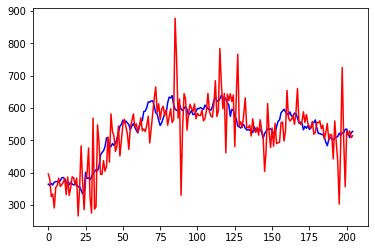

In [ ]:
# Multivariate CNN Model with 5 days input and predicting 5 days output

start = time.time()
execute(stock_df, ('multivariate', 1, (5,4), 1150, 32))
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')
plot_model(model, to_file='cnn_uni_1.png', show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 4)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 16)             208       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/600
19/19 [==============================] - 0s 1ms/step - loss: 45585275.8000
Epoch 2/600
19/19 [==================

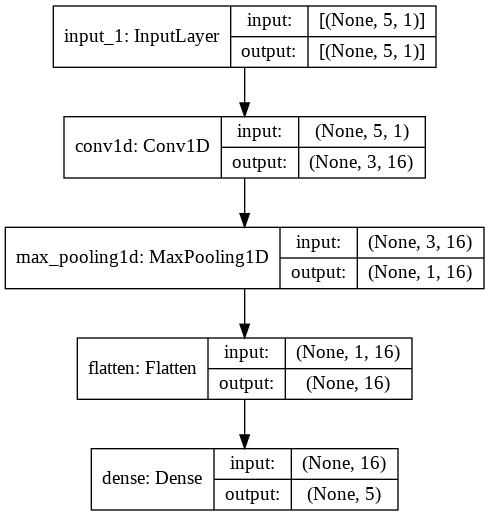

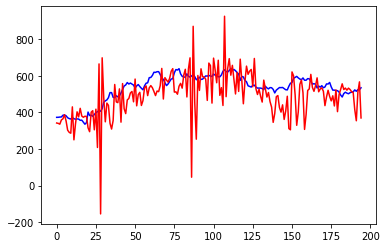

In [ ]:
# Univariate CNN Model with 10 days input and predicting 5 days output
start = time.time()
execute(stock_df, ('multivariate', 2, (10,4), 600, 16))
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')
plot_model(model, to_file='cnn_uni_1.png', show_shapes=True)

## 3.b. LSTM

In [ ]:
# Importing neccessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize



In [ ]:
# Reading csv file as DataFrame

stock_df = pd.read_csv('/content/Century_data_imputed.csv')
stock_df.head()

,date,time,open,low,high,close,volume
0,07-01-2013,09:30:00,447.75,447.75,449.45,449.45,8112
1,07-01-2013,09:35:00,449.35,449.35,451.80,451.55,27301
2,07-01-2013,09:40:00,451.60,450.00,451.80,450.40,13994
3,07-01-2013,09:45:00,450.45,449.30,451.00,449.35,6240
4,07-01-2013,09:50:00,449.30,447.40,449.75,448.00,9152


In [ ]:
def average(df, dtype):
    
    avg_daily_open_prices = []
    
    for day in range(0,len(df)-73+1,73):
        avg_daily_open_prices.append(round(np.mean(df[day:day+73]),4))
        
    avg_daily_open_prices_np = np.array(avg_daily_open_prices)
    
    if dtype.lower() == 'univariate':
        avg_daily_open_prices_np = avg_daily_open_prices_np.reshape(-1,1)
    
        
    return avg_daily_open_prices_np

In [ ]:
def generate_train_test_data(df, dtype):
    
    if dtype.lower() == 'univariate':
        X = df.open
    elif dtype.lower() == 'multivariate':
        X = stock_df.drop(columns=['date', 'time'])
        
    averaged_X = average(X, dtype)
    
    train_data = averaged_X[:round(averaged_X.shape[0]*3/5)]
    test_data = averaged_X[round(averaged_X.shape[0]*3/5):]
    
    train_data = train_data.reshape(train_data.shape[0]//5, 5, train_data.shape[1])
    test_data = test_data.reshape(test_data.shape[0]//5, 5, test_data.shape[1])
    
    return train_data, test_data

In [ ]:
def process_train_data(train_df, week=1):
    
    train_df_reshaped = train_df.reshape(train_df.shape[0]*train_df.shape[1], train_df.shape[2])
    
    train_X_arr = []
    train_y_arr = []
    
    for i in range(len(train_df_reshaped)):
        
        temp_x = train_df_reshaped[i:i+(week*5), 0 if train_df_reshaped.shape[1]==1 else 1:]
        temp_y = train_df_reshaped[i+(week*5):i+((week*5)+5),0:1]
        
        if len(temp_x) == (week*5) and len(temp_y) == 5:
            train_X_arr.append(temp_x)
            train_y_arr.append(temp_y)
            
    train_X = np.array((train_X_arr)).reshape(len(train_X_arr), (week*5), len(train_X_arr[0][0]))
    train_y = np.array((train_y_arr)).reshape(len(train_y_arr), 5, 1)
    
    return train_X, train_y

In [ ]:
def process_test_data(data, shift_period, dtype):
    
    df = None
    
    shape_0, shape_1, shape_2 = data.shape
    
    data_reshaped = data.reshape(shape_0*shape_1, shape_2)
    
    if dtype.lower() == 'univariate':
        df = pd.DataFrame({'X':pd.Series(np.squeeze(data_reshaped)),'Y':pd.Series(np.squeeze(data_reshaped))})
        df.X = df.X.shift(periods=shift_period)
    elif dtype.lower() == 'multivariate':
        df = pd.concat([pd.DataFrame(data_reshaped[:,1:], columns=['X1', 'X2', 'X3', 'X4']), 
                        pd.DataFrame(data_reshaped[:,0], columns=['Y'])], axis=1)
        df.iloc[:,:-1] = df.iloc[:,:-1].shift(periods=shift_period)
        
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [ ]:
def normalize_data(data):
    shape_0, shape_1, shape_2 = data.shape
    normalized_data = normalize(data.reshape(shape_0*shape_1, shape_2))
    return data
    return normalized_data.reshape(shape_0, shape_1, shape_2)



---



---



LSTM



---



---



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Reshape, Dense
from tensorflow.keras.layers import Flatten
#from keras.layers import LeakyReLU
import keras
from sklearn.metrics import mean_squared_error
from keras.utils import plot_model
import time

In [ ]:
keras.backend.clear_session()

In [ ]:
# train the model
def build_model(train_x, train_y, n_input):
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
  model = Sequential()
  model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(Dense(75, activation='relu'))
  model.add(Dense(75, activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mse', optimizer='adam')
  return model

def train_model(model, X, y, epochs, batch_size, verbose):

  model.compile(optimizer='adam', loss='mse')
  x = normalize_data(X) if X.shape[2]==4 else X
  model.fit(x=x, y=y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model
 

# evaluate the model
def evaluate_model(model, test_data_df, shift_period=5):

   predictions = []
   actual = []

   # iterating through the test data and appending predicted and actual values to the corresponding arrays 
   for i in range(0,len(test_data_df)-shift_period+1, 5):


     if len(test_data_df.columns) == 5:
            test_X = np.array(test_data_df.iloc[i:i+shift_period,0:4])
            test_X_reshaped = test_X.reshape(1,test_X.shape[0],test_X.shape[1])
            test_X_reshaped = normalize_data(test_X_reshaped)
     else:
            test_X = np.array(test_data_df.iloc[i:i+shift_period,0:1])
            test_X_reshaped = test_X.reshape(1,test_X.shape[0],test_X.shape[1])

     yhat = model.predict(test_X_reshaped, verbose=0)
     predictions.append(yhat[0].reshape(-1,1))
     actual.append(np.array(test_data_df[i:i+5].Y).reshape(-1,1))

   return predictions, actual


# calculating the metrics and plot 
def compute_rmse_and_plot(actual, predictions):

  rmse = np.sqrt(mean_squared_error(np.array(actual).flatten(),np.array(predictions).flatten()))
  rmse_per_mean_target = rmse / np.mean(np.array(actual))
  print('==============================================================')
  print("RMSE: ", rmse)
  print('RMSE to Mean: ',rmse_per_mean_target)
  print('===============================================================')
  plt.plot(np.array(actual).reshape(-1,1), label='actual')
  plt.plot(np.array(predictions).reshape(-1,1), label='prediction')
  plt.legend()
        

RMSE:  28.045613828246054
RMSE to Mean:  0.05324459208273077
time
9.262531042098999


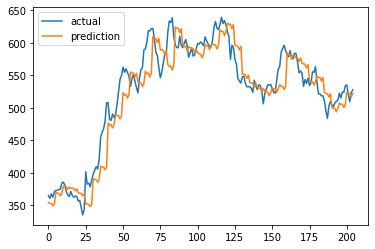

In [ ]:
start = time.time()
model_type, week_inp, inp_shape = ('univariate', 1, (5,1))
train_data, test_data = generate_train_test_data(stock_df, model_type)
train_X, train_y = process_train_data(train_data, week=week_inp)
test_data_df = process_test_data(data=test_data, shift_period=week_inp*5, dtype=model_type)

n_input, verbose, epochs, batch_size = 5, 0, 20, 8
keras.backend.clear_session()
model = build_model(train_X, train_y, n_input)
train_model(model, X=train_X, y=train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
predictions, actual = evaluate_model(model, test_data_df, shift_period=week_inp*5)
compute_rmse_and_plot(predictions=predictions, actual=actual)
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')

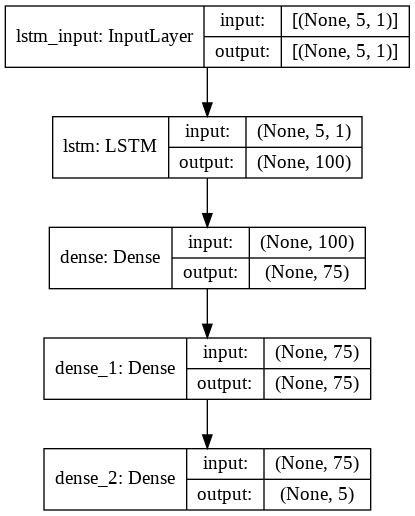

In [ ]:
plot_model(model, to_file='lstm_univariate_1.png', show_shapes=True)

RMSE:  29.097560147769144
RMSE to Mean:  0.05480077596963767
time
9.091719388961792


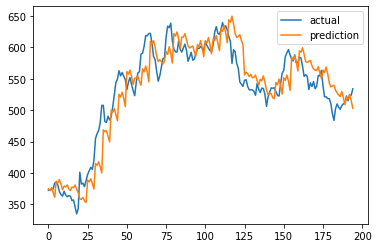

In [ ]:
start = time.time()
model_type, week_inp, inp_shape = ('univariate', 2, (10,1))
train_data, test_data = generate_train_test_data(stock_df, model_type)
train_X, train_y = process_train_data(train_data, week=week_inp)
test_data_df = process_test_data(data=test_data, shift_period=week_inp*5, dtype=model_type)

n_inputs, verbose, epochs, batch_size = 10, 0, 20, 8
keras.backend.clear_session()
model = build_model(train_X, train_y, n_input)
train_model(model, X=train_X, y=train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
predictions, actual = evaluate_model(model, test_data_df, shift_period=week_inp*5)
compute_rmse_and_plot(predictions=predictions, actual=actual)
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')


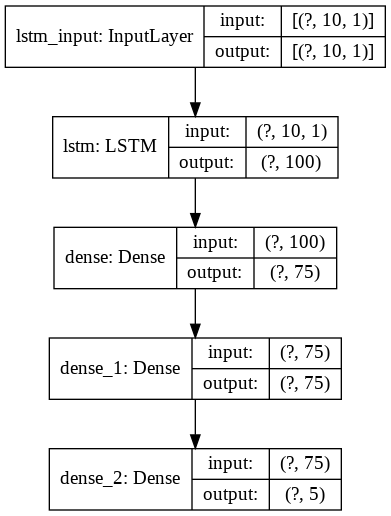

In [ ]:
plot_model(model, to_file='lstm_univariate_2.png', show_shapes=True)

RMSE:  70.54316442912136
RMSE to Mean:  0.13392618315491042
time
28.537216424942017


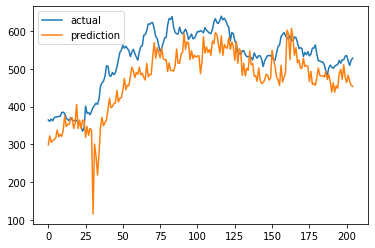

In [ ]:
start = time.time()
model_type, week_inp, inp_shape = ('multivariate', 1, (10,4))
train_data, test_data = generate_train_test_data(stock_df, model_type)
train_X, train_y = process_train_data(train_data, week=week_inp)
test_data_df = process_test_data(data=test_data, shift_period=week_inp*5, dtype=model_type)

n_inputs, verbose, epochs, batch_size = 10, 0, 300, 32
keras.backend.clear_session()
model = build_model(train_X, train_y, n_input)
train_model(model, X=train_X, y=train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
predictions, actual = evaluate_model(model, test_data_df, shift_period=week_inp*5)
compute_rmse_and_plot(predictions=predictions, actual=actual)
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')

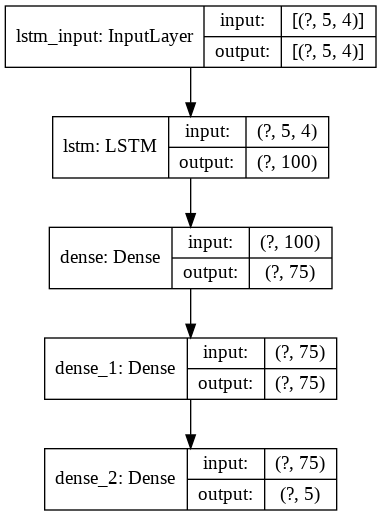

In [ ]:
plot_model(model, to_file='lstm_multivariate_1.png', show_shapes=True)

RMSE:  142.55275622620982
RMSE to Mean:  0.26847617525780176
time
33.87923455238342


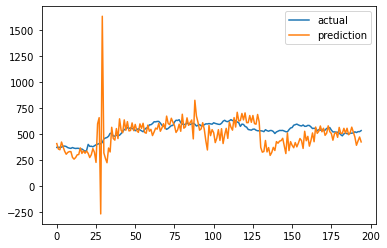

In [ ]:
start = time.time()
model_type, week_inp, inp_shape = ('multivariate', 2, (10,4))
train_data, test_data = generate_train_test_data(stock_df, model_type)
train_X, train_y = process_train_data(train_data, week=week_inp)
test_data_df = process_test_data(data=test_data, shift_period=week_inp*5, dtype=model_type)

n_inputs, verbose, epochs, batch_size = 10, 0, 300, 32
keras.backend.clear_session()
model = build_model(train_X, train_y, n_input)
train_model(model, X=train_X, y=train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
predictions, actual = evaluate_model(model, test_data_df, shift_period=week_inp*5)
compute_rmse_and_plot(predictions=predictions, actual=actual)
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')

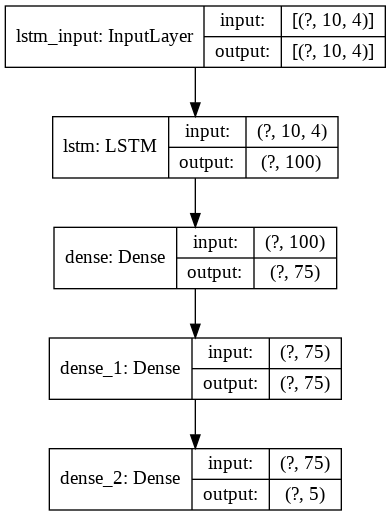

In [ ]:
plot_model(model, to_file='lstm_multivariate_2.png', show_shapes=True)



---

---







LSTM with attention



---

---





In [ ]:
from keras.layers import Layer
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Model

In [ ]:
# building the attention layer
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
# include the attention layer in the architecture
K.clear_session()
def build_attention_model(train_x, train_y, n_input):
  
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

  inputs=Input((n_timesteps,n_features))
  att_in=LSTM(25,activation='relu', return_sequences=True)(inputs)
  att_out=attention()(att_in)
  layer1 = Dense(25,trainable=True, activation='relu')(att_out)
  layer2 = Dense(n_outputs)(layer1)
  outputs = Dense(n_outputs)(layer1)
  outputs = tf.keras.layers.Reshape((n_outputs,1))(outputs)
  model=Model(inputs,outputs)
  return model

In [ ]:
def train_attention_model(X,y, epochs, verbose, batch_size, model):
  model.compile(loss='mse', optimizer='adam')
  x = normalize_data(X) if X.shape[2]==4 else X
  model.fit(x, y, epochs=epochs, verbose=verbose, batch_size=batch_size)
  return model

RMSE:  43.73217527286783
RMSE to Mean:  0.08236282106206412
time
36.600948333740234


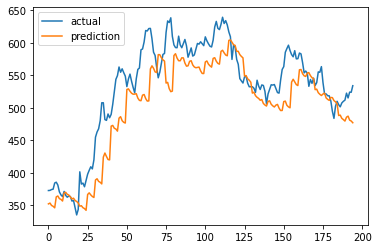

In [ ]:
start = time.time()
model_type, week_inp, inp_shape = ('univariate', 2, (10,1))
train_data, test_data = generate_train_test_data(stock_df, model_type)
train_X, train_y = process_train_data(train_data, week=week_inp)
test_data_df = process_test_data(data=test_data, shift_period=week_inp*5, dtype=model_type)

n_input, verbose, epochs, batch_size = 10, 0, 300, 16 
keras.backend.clear_session()
model  = build_attention_model(train_X, train_y, n_input)
train_attention_model(X=train_X, y=train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, model=model)
predictions, actual = evaluate_model(model, test_data_df, shift_period=week_inp*5)
compute_rmse_and_plot(predictions=predictions, actual=actual)
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')

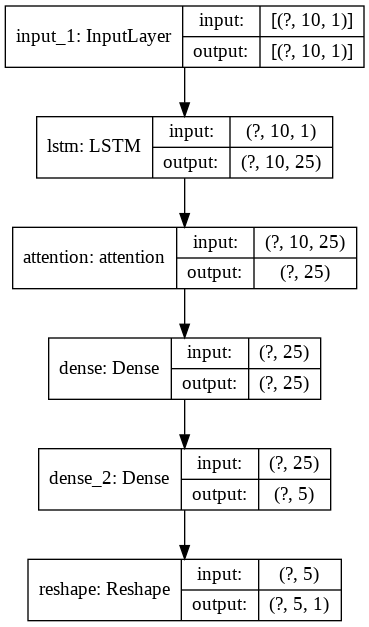

In [ ]:
plot_model(model, to_file='lstm_attention_uni.png', show_shapes=True)

RMSE:  121.65494184048012
RMSE to Mean:  0.22911835836210417
time
24.43101668357849


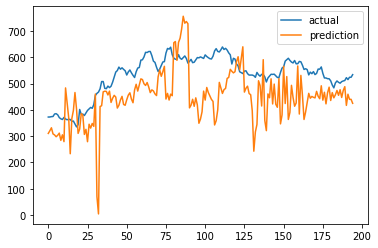

In [ ]:
start = time.time()
model_type, week_inp, inp_shape = ('multivariate', 2, (10,1))
train_data, test_data = generate_train_test_data(stock_df, model_type)
train_X, train_y = process_train_data(train_data, week=week_inp)
test_data_df = process_test_data(data=test_data, shift_period=week_inp*5, dtype=model_type)

n_input, verbose, epochs, batch_size = 10, 0, 300, 32
keras.backend.clear_session()
model  = build_attention_model(train_X, train_y, n_input)
train_attention_model(X=train_X, y=train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, model=model)
predictions, actual = evaluate_model(model, test_data_df, shift_period=week_inp*5)
compute_rmse_and_plot(predictions=predictions, actual=actual)
end = time.time()
print('==============================================================')
print('time')
print(end-start)
print('==============================================================')

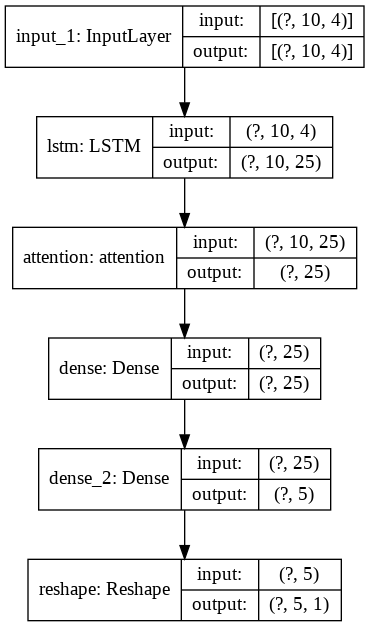

In [ ]:
plot_model(model, to_file='lstm_attention_multi.png', show_shapes=True)